In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

datadir = '../../../../Data/RSNA_2022_DATA/rsna-2022-cervical-spine-fracture-detection'
libdir = '.'
outputdir = '.'
otherdir = '.'
train_bs_ = 2
valid_bs_ = 4
num_workers_ = 5

In [23]:
class CFG:
    seed=42
    device='GPU'
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5

    target_cols=["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    num_classes=7

    accum_iter=4
    max_grad_norm=1000
    print_freq=100
    normalize_mean=[0.4824, 0.4824, 0.4824] # [0.485, 0.456, 0.406] [0.4824, 0.4824, 0.4824]
    normalize_std=[0.22, 0.22, 0.22] # [0.229, 0.224, 0.225] [0.22, 0.22, 0.22]
    
    suffix="406" 
    fold_list=[0,1,2,3,4] 
    epochs=20
    model_arch="resnest50d" # tf_efficientnetv2_s, resnest50d
    img_size=400
    optimizer="AdamW"
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup="GradualWarmupSchedulerV3" 

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 
    
    seq_len = 24
    lr=5e-5
    min_lr=1e-7
    weight_decay=0
    dropout=0.1

    gpu_parallel=False
    n_early_stopping=5
    debug=False
    multihead=False

# Import

In [24]:
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom
import gc 
from torch.nn import DataParallel



if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

/tmp/ipykernel_1312693/3161884775.py:41: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


# helper

In [25]:
train_df = pd.read_pickle(f'{datadir}/vertebrae_df.pkl')
submission_df = pd.read_csv(f'{datadir}/sample_submission.csv')

train_df = train_df[~train_df["StudyInstanceUID"].isin(["1.2.826.0.1.3680043.20574", "1.2.826.0.1.3680043.29952"]) ].reset_index(drop=True)

gkf = GroupKFold(n_splits=CFG.fold_num)
folds = gkf.split(X=train_df, y=None, groups=train_df['StudyInstanceUID'])


train_df

,study_cid,StudyInstanceUID,cid,slice_num_list,before_image_size,x0,x1,y0,y1,z0,z1,label
0,1.2.826.0.1.3680043.10001_1,1.2.826.0.1.3680043.10001,1,"[51, 52, 53, 54, 56, 57, 58, 59, 61, 62, 63, 6...",512,0,268,69,396,105,442,0
1,1.2.826.0.1.3680043.10001_2,1.2.826.0.1.3680043.10001,2,"[81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 9...",512,0,268,69,396,105,442,0
2,1.2.826.0.1.3680043.10001_3,1.2.826.0.1.3680043.10001,3,"[40, 108, 109, 110, 111, 112, 113, 114, 115, 1...",512,0,268,69,396,105,442,0
3,1.2.826.0.1.3680043.10001_4,1.2.826.0.1.3680043.10001,4,"[127, 128, 130, 131, 132, 133, 134, 135, 136, ...",512,0,268,69,396,105,442,0
4,1.2.826.0.1.3680043.10001_5,1.2.826.0.1.3680043.10001,5,"[1, 153, 155, 156, 158, 159, 160, 161, 162, 16...",512,0,268,69,396,105,442,0
...,...,...,...,...,...,...,...,...,...,...,...,...
313,1.2.826.0.1.3680043.10945_3,1.2.826.0.1.3680043.10945,3,"[107, 108, 109, 111, 112, 115, 116, 118, 119, ...",512,0,219,32,442,116,399,0
314,1.2.826.0.1.3680043.10945_4,1.2.826.0.1.3680043.10945,4,"[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",512,0,219,32,442,116,399,0
315,1.2.826.0.1.3680043.10945_5,1.2.826.0.1.3680043.10945,5,"[164, 165, 166, 167, 168, 169, 170, 171, 183, ...",512,0,219,32,442,116,399,0
316,1.2.826.0.1.3680043.10945_6,1.2.826.0.1.3680043.10945,6,"[172, 173, 174, 175, 176, 177, 178, 179, 180, ...",512,0,219,32,442,116,399,0


In [26]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
    
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=outputdir+'stage2_train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'/stage2_train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print



def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

# DataSet

In [28]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_id = row["StudyInstanceUID"]
        slice_num_list = row['slice_num_list']
        before_image_size = row["before_image_size"]
        y0 = row["y0"]; y1 = row["y1"];
        z0 = row["z0"]; z1 = row["z1"];

        slice_list = []
        for s_num in slice_num_list:
            path = f"{datadir}/train_images/{study_id}/{s_num}.dcm"
            img = load_dicom(path)
            if len(slice_list) == 0:
                imgh = img.shape[0]
                imgw = img.shape[1]
            elif img.shape != (imgh, imgw):
                img = cv2.resize(img,(imgh,imgw))

            slice_list.append(img)
        for _ in range(CFG.seq_len - len(slice_list)):
            slice_list.append(np.zeros((imgh,imgw)))

        image = np.stack(slice_list, axis=2) # 512*512*seq_len; 0-1
        image = cv2.resize(image, (before_image_size, before_image_size))
        image = image[y0:y1, z0:z1, :]

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        image = np.transpose(image, (2, 0, 1)) # seq_len*img_size*img_size; 0-1
        return torch.from_numpy(image), torch.tensor(row['label']).float()

In [29]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(*, data):
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1), 
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
            RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
            CLAHE(clip_limit=(1,4), p=0.5),
            OneOf([
                OpticalDistortion(distort_limit=1.0),
                GridDistortion(num_steps=5, distort_limit=1.),
                ElasticTransform(alpha=3),
            ], p=0.2),
            OneOf([
                GaussNoise(var_limit=[10, 50]),
                GaussianBlur(),
                MotionBlur(),
                MedianBlur(),
            ], p=0.2),
            Resize(CFG.img_size, CFG.img_size),
            OneOf([
                JpegCompression(),
                Downscale(scale_min=0.1, scale_max=0.15),
            ], p=0.2),
            IAAPiecewiseAffine(p=0.2),
            IAASharpen(p=0.2),
            Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),
            ])
    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),
            OneOf([
                # GaussNoise(),
                GaussianBlur(),
                MotionBlur(),
                # MedianBlur(),
            ], p=0.3),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.3),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)    
    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
        ])

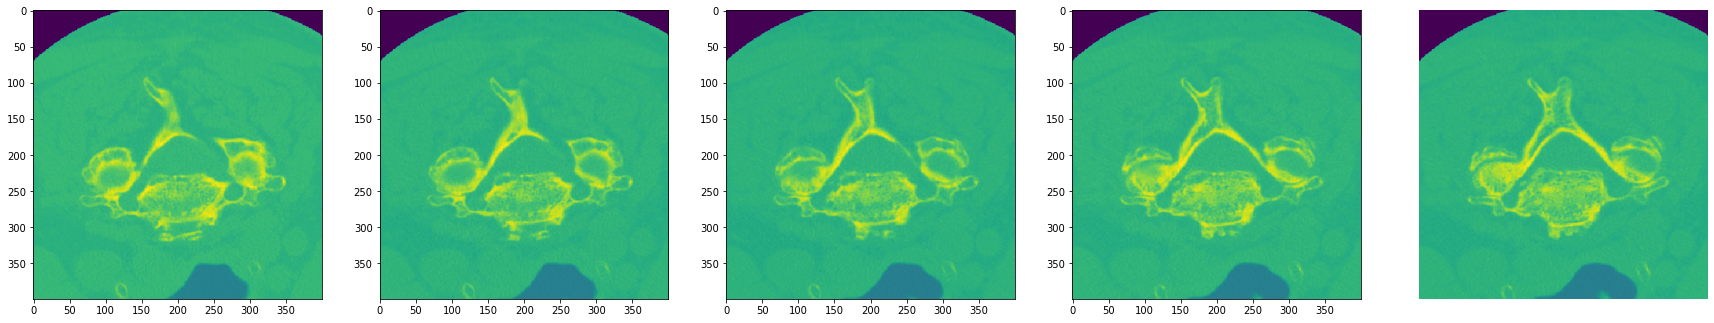

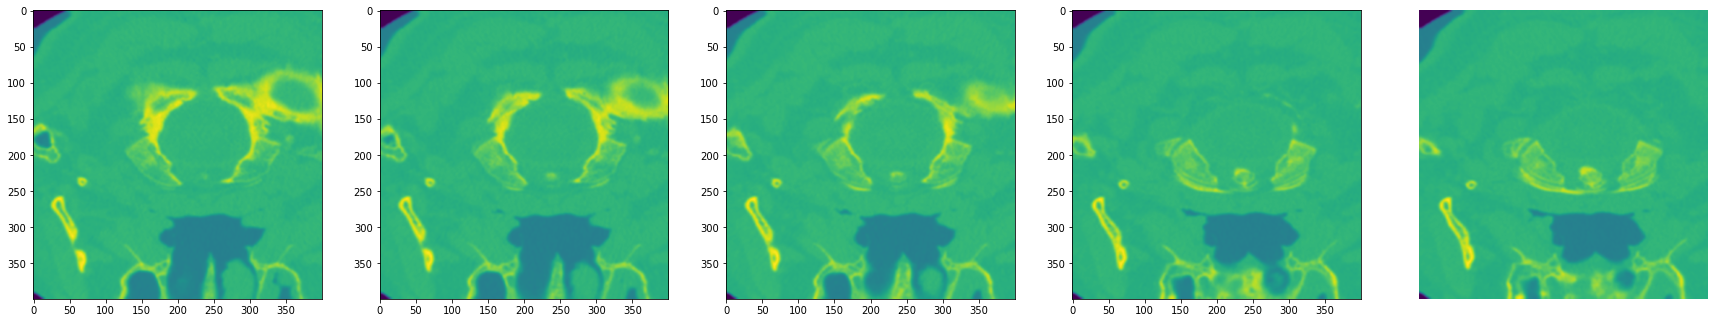

In [30]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df,
    transform=get_transforms(data='light_train') # None, get_transforms(data='check')
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,5)
    idx = np.random.randint(0, len(dataset_show))
    img, label= dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');
    axarr[3].imshow(img[3]); plt.axis('OFF');
    axarr[4].imshow(img[4]); plt.axis('OFF');

# Model

In [31]:
import torch.nn as nn
from itertools import repeat

class SpatialDropout(nn.Module):
    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1]) 
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


import torch
from torch import nn
import torch.nn.functional as F

from typing import Dict, Optional
 
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor


    
class MLPAttentionNetwork(nn.Module):
 
    def __init__(self, hidden_dim, attention_dim=None):
        super(MLPAttentionNetwork, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        if self.attention_dim is None:
            self.attention_dim = self.hidden_dim
        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)
 
    def forward(self, x):
        """
        :param x: seq_len, batch_size, hidden_dim
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        # print(f"x shape:{x.shape}")
        batch_size, seq_len, _ = x.size()
        # flat_inputs = x.reshape(-1, self.hidden_dim) # (batch_size*seq_len, hidden_dim)
        # print(f"flat_inputs shape:{flat_inputs.shape}")
        
        H = torch.tanh(self.proj_w(x)) # (batch_size, seq_len, hidden_dim)
        # print(f"H shape:{H.shape}")
        
        att_scores = torch.softmax(self.proj_v(H),axis=1) # (batch_size, seq_len)
        # print(f"att_scores shape:{att_scores.shape}")
        
        attn_x = (x * att_scores).sum(1) # (batch_size, hidden_dim)
        # print(f"attn_x shape:{attn_x.shape}")
        return attn_x

In [32]:
class RSNAClassifier(nn.Module):
    def __init__(self, model_arch, hidden_dim=256, seq_len=24, pretrained=False):
        super().__init__()
        self.seq_len = seq_len
        self.model = timm.create_model(model_arch, in_chans=1, pretrained=pretrained)

        if 'efficientnet' in CFG.model_arch:
            cnn_feature = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
        elif "res" in CFG.model_arch:
            cnn_feature = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)
        
        self.spatialdropout = SpatialDropout(CFG.dropout)
        self.gru = nn.GRU(cnn_feature, hidden_dim, 2, batch_first=True, bidirectional=True)
        self.mlp_attention_layer = MLPAttentionNetwork(2 * hidden_dim)
        self.logits = nn.Sequential(
            nn.Linear(hidden_dim*2, 128),
            nn.ReLU(),
            nn.Dropout(CFG.dropout),
            nn.Linear(128, 1)
        )

        # for n, m in self.named_modules():
        #     if isinstance(m, nn.GRU):
        #         print(f"init {m}")
        #         for param in m.parameters():
        #             if len(param.shape) >= 2:
        #                 nn.init.orthogonal_(param.data)
        #             else:
        #                 nn.init.normal_(param.data)

    def forward(self, x): # (B, seq_len, H, W)
        bs = x.size(0) 
        x = x.reshape(bs*self.seq_len, 1, x.size(2), x.size(3)) # (B*seq_len, 1, H, W)
        features = self.model(x)   
        if "res" in CFG.model_arch:                             
            features = self.pooling(features).view(bs*self.seq_len, -1) # (B*seq_len, cnn_feature)
        features = self.spatialdropout(features)                # (B*seq_len, cnn_feature)
        # print(features.shape)
        features = features.reshape(bs, self.seq_len, -1)       # (B, seq_len, cnn_feature)
        features, _ = self.gru(features)                        # (B, seq_len, hidden_dim*2)
        atten_out = self.mlp_attention_layer(features)          # (B, hidden_dim*2)
        pred = self.logits(atten_out)                           # (B, 1)
        pred = pred.view(bs, -1)                                # (B, 1)
        return pred

In [33]:
model = RSNAClassifier(CFG.model_arch, hidden_dim=256, seq_len=24, pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_s-eb54923e.pth" to /home/apaddo/.cache/torch/hub/checkpoints/tf_efficientnetv2_s-eb54923e.pth


In [34]:
def get_activation(activ_name: str="relu"):
    """"""
    act_dict = {
        "relu": nn.ReLU(inplace=True),
        "tanh": nn.Tanh(),
        "sigmoid": nn.Sigmoid(),
        "identity": nn.Identity()}
    if activ_name in act_dict:
        return act_dict[activ_name]
    else:
        raise NotImplementedError
        

class Conv2dBNActiv(nn.Module):
    """Conv2d -> (BN ->) -> Activation"""
    
    def __init__(
        self, in_channels, out_channels,
        kernel_size, stride, padding,
        bias=False, use_bn=True, activ="relu"
    ):
        """"""
        super(Conv2dBNActiv, self).__init__()
        layers = []
        layers.append(nn.Conv2d(
            in_channels, out_channels,
            kernel_size, stride, padding, bias=bias))
        if use_bn:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(get_activation(activ))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward"""
        return self.layers(x)
        
    
class SpatialAttentionBlock(nn.Module):
    """Spatial Attention for (C, H, W) feature maps"""
    
    def __init__(
        self, in_channels,
        out_channels_list,
    ):
        """Initialize"""
        super(SpatialAttentionBlock, self).__init__()
        self.n_layers = len(out_channels_list)
        channels_list = [in_channels] + out_channels_list
        assert self.n_layers > 0
        assert channels_list[-1] == 1
        
        for i in range(self.n_layers - 1):
            in_chs, out_chs = channels_list[i: i + 2]
            layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="relu")
            setattr(self, f"conv{i + 1}", layer)
            
        in_chs, out_chs = channels_list[-2:]
        layer = Conv2dBNActiv(in_chs, out_chs, 3, 1, 1, activ="sigmoid")
        setattr(self, f"conv{self.n_layers}", layer)
    
    def forward(self, x):
        """Forward"""
        h = x
        for i in range(self.n_layers):
            h = getattr(self, f"conv{i + 1}")(h)
            
        h = h * x
        return h



class MultiHeadResNet200D(nn.Module):
    def __init__(self, out_dims_head=[3, 4, 3, 1],  pretrained=False):
        self.base_name = "resnet200d_320"
        self.n_heads = len(out_dims_head)
        super(MultiHeadResNet200D, self).__init__()
        
        # # load base model
        base_model = timm.create_model(self.base_name, num_classes=sum(out_dims_head), pretrained=False)
        in_features = base_model.num_features
        
        if pretrained:
            pretrained_model_path = CFG.student
            state_dict = dict()
            for k, v in torch.load(pretrained_model_path, map_location='cpu')["model"].items():
                if k[:6] == "model.":
                    k = k.replace("model.", "")
                state_dict[k] = v
            base_model.load_state_dict(state_dict)
        
        # # remove global pooling and head classifier
        base_model.reset_classifier(0, '')
        
        # # Shared CNN Bacbone
        self.backbone = base_model
        
        # # Multi Heads.
        for i, out_dim in enumerate(out_dims_head):
            layer_name = f"head_{i}"
            layer = nn.Sequential(
                SpatialAttentionBlock(in_features, [64, 32, 16, 1]),
                nn.AdaptiveAvgPool2d(output_size=1),
                nn.Flatten(start_dim=1),
                nn.Linear(in_features, in_features),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(in_features, out_dim))
            setattr(self, layer_name, layer)

    def forward(self, x):
        h = self.backbone(x)
        hs = [getattr(self, f"head_{i}")(h) for i in range(self.n_heads)]
        y = torch.cat(hs, axis=1)
        return None, None, y

In [35]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        batch_size = labels.size(0)

        if CFG.device == 'GPU':
            with autocast():
                y_preds = model(images)
                y_preds = y_preds.squeeze(1)
                loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            scaler.scale(loss).backward()
            grad_norm = 0 # torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        elif CFG.device == 'TPU':
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.accum_iter > 1:
                loss = loss / CFG.accum_iter
            loss.backward()
            grad_norm = 0 # torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.accum_iter == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            cusprint('Epoch: [{0}][{1}/{2}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                'Grad: {grad_norm:.4f}  '
                'LR: {lr:.7f}  '
                .format(
                epoch, step, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(train_loader)),
                grad_norm=grad_norm,
                lr=optimizer.param_groups[0]["lr"],
                ))

    return losses.avg, optimizer.param_groups[0]["lr"]

In [36]:
def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
            y_preds = y_preds.squeeze(1)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            cusprint('EVAL: [{0}/{1}] '
                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                step, len(valid_loader), batch_time=batch_time,
                data_time=data_time, loss=losses,
                remain=timeSince(start, float(step+1)/len(valid_loader)),
                ))

    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    print(f"trues.shape: {trues.shape}")
    print(f"predictions.shape: {predictions.shape}")
    score = nn.BCEWithLogitsLoss()(torch.from_numpy(predictions).type(torch.float32), torch.from_numpy(trues).type(torch.float32))
    return losses.avg, predictions, trues, score

# loss & optimizer & scheduler

In [37]:
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

# Training

In [38]:
def train_loop(df, fold, trn_idx, val_idx):
    loginfo(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = train_df.loc[trn_idx].reset_index(drop=True)
    valid_folds = train_df.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='light_train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, sampler=train_sampler, drop_last=True, num_workers=CFG.num_workers)
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal(), shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, sampler=valid_sampler, drop_last=False, num_workers=CFG.num_workers)

    # ====================================================
    # model & optimizer & scheduler & loss
    # ====================================================
    # not checkpoint

    if CFG.multihead:
        model = MultiHeadResNet200D([3, 4, 3, 1], True)
    else:
        model = RSNAClassifier(CFG.model_arch, hidden_dim=256, seq_len=24, pretrained=True)

        
    if CFG.gpu_parallel:    
        num_gpu = torch.cuda.device_count()
        model = DataParallel(model, device_ids=range(num_gpu))
    model.to(device)
    
    model = torch.quantization.convert(model.eval(), inplace=False)
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 5e-5)
    model.qconfig = torch.ao.quantization.get_default_qat_qconfig('fbgemm')
    
    # optimizer
    if CFG.optimizer == "AdamW":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = AdamW(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=CFG.warmup_factor, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    # loss
    if CFG.loss_fn == "BCEWithLogitsLoss":
        criterion = nn.BCEWithLogitsLoss()

    # ====================================================
    # loop
    # ====================================================
    valid_acc_max=0; valid_loss_min=float("inf")
    valid_acc_max_cnt=0; valid_loss_min_cnt=0;
    best_acc_epoch=0;


    for epoch in range(CFG.epochs):
        loginfo(f"***** Epoch {epoch} *****")

        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            loginfo(f"schwarmup_last_epoch:{scheduler_warmup.last_epoch}, schwarmup_lr:{scheduler_warmup.get_last_lr()[0]}")
        if CFG.scheduler=='CosineAnnealingLR':
            loginfo(f"scheduler_last_epoch:{scheduler.last_epoch}, scheduler_lr:{scheduler.get_last_lr()[0]}")
        loginfo(f"optimizer_lr:{optimizer.param_groups[0]['lr']}")

                
        start_time = time.time()
        avg_loss, cur_lr = train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device) # train
        avg_val_loss, preds, trues, score = valid_one_epoch(valid_loader, model, criterion, device) # valid

        # scoring
        elapsed = time.time() - start_time 

        loginfo(f'Epoch {epoch} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        loginfo(f'Epoch {epoch} - valid score: {score:.4f}')

        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            scheduler_warmup.step()
        elif CFG.scheduler == "ReduceLROnPlateau":
            scheduler.step(avg_val_loss)
        elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
            scheduler.step()

        # early stopping
        if avg_val_loss < valid_loss_min:
            valid_loss_min = avg_val_loss
            valid_loss_min_cnt=0
            best_acc_epoch = epoch
        else:
            valid_loss_min_cnt+=1

        if valid_loss_min_cnt >= CFG.n_early_stopping:
            if CFG.device == 'GPU':
                torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            elif CFG.device == 'TPU':
                xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
            print("early_stopping")
            break

        if CFG.device == 'GPU':
            torch.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
        elif CFG.device == 'TPU':
            xm.save({'model': model.state_dict()}, outputdir+f'/{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{epoch}.pth')
    
    return preds, trues

In [39]:
def main():
    oof_df = pd.DataFrame()
    oof_list = []
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold in CFG.fold_list:
            preds, trues = train_loop(train_df, fold, trn_idx, val_idx)
            oof_list.append([preds, trues])
    return oof_list

# Main

In [40]:
if __name__ == '__main__':
    print(CFG.suffix)
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        oof_list = main()


========== fold: 0 training ==========
========== fold: 0 training ==========


406


***** Epoch 0 *****
***** Epoch 0 *****
schwarmup_last_epoch:0, schwarmup_lr:5e-06
schwarmup_last_epoch:0, schwarmup_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-06
optimizer_lr:5e-06


Epoch: [0][0/127] Data 1.415 (1.415) Elapsed 0m 7s (remain 16m 42s) Loss: 0.6265(0.6265) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][100/127] Data 0.000 (0.142) Elapsed 1m 15s (remain 0m 19s) Loss: 0.6138(0.6414) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][126/127] Data 0.000 (0.113) Elapsed 1m 29s (remain 0m 0s) Loss: 0.6014(0.6349) Grad: 0.0000  LR: 0.0000050  


/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:955: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


EVAL: [0/16] Data 1.280 (1.280) Elapsed 0m 3s (remain 0m 45s) Loss: 0.6322(0.6322) 


Epoch 0 - avg_train_loss: 0.6349  avg_val_loss: 0.6502  time: 100s
Epoch 0 - avg_train_loss: 0.6349  avg_val_loss: 0.6502  time: 100s
Epoch 0 - valid score: 0.6502
Epoch 0 - valid score: 0.6502


EVAL: [15/16] Data 0.000 (0.080) Elapsed 0m 11s (remain 0m 0s) Loss: 0.6446(0.6502) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 1 *****
***** Epoch 1 *****
schwarmup_last_epoch:1, schwarmup_lr:5e-05
schwarmup_last_epoch:1, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [1][0/127] Data 0.981 (0.981) Elapsed 0m 1s (remain 2m 38s) Loss: 0.7864(0.7864) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][100/127] Data 0.000 (0.012) Elapsed 0m 54s (remain 0m 13s) Loss: 0.1148(0.4772) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][126/127] Data 0.000 (0.009) Elapsed 1m 7s (remain 0m 0s) Loss: 0.1146(0.4547) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 1.293 (1.293) Elapsed 0m 1s (remain 0m 26s) Loss: 0.1496(0.1496) 


Epoch 1 - avg_train_loss: 0.4547  avg_val_loss: 0.3842  time: 77s
Epoch 1 - avg_train_loss: 0.4547  avg_val_loss: 0.3842  time: 77s
Epoch 1 - valid score: 0.3842
Epoch 1 - valid score: 0.3842


EVAL: [15/16] Data 0.000 (0.081) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1228(0.3842) 
trues.shape: (63,)
predictions.shape: (63,)


/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
***** Epoch 2 *****
***** Epoch 2 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [2][0/127] Data 1.248 (1.248) Elapsed 0m 1s (remain 3m 11s) Loss: 0.0693(0.0693) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][100/127] Data 0.000 (0.013) Elapsed 0m 54s (remain 0m 14s) Loss: 0.0726(0.3342) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][126/127] Data 0.000 (0.010) Elapsed 1m 8s (remain 0m 0s) Loss: 0.1308(0.3462) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 1.359 (1.359) Elapsed 0m 1s (remain 0m 27s) Loss: 0.1283(0.1283) 


Epoch 2 - avg_train_loss: 0.3462  avg_val_loss: 0.3853  time: 77s
Epoch 2 - avg_train_loss: 0.3462  avg_val_loss: 0.3853  time: 77s
Epoch 2 - valid score: 0.3853
Epoch 2 - valid score: 0.3853


EVAL: [15/16] Data 0.000 (0.085) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1282(0.3853) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 3 *****
***** Epoch 3 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05


Epoch: [3][0/127] Data 1.054 (1.054) Elapsed 0m 1s (remain 2m 47s) Loss: 0.0663(0.0663) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][100/127] Data 0.003 (0.201) Elapsed 1m 21s (remain 0m 20s) Loss: 0.1176(0.3622) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][126/127] Data 0.000 (0.186) Elapsed 1m 43s (remain 0m 0s) Loss: 0.1455(0.3432) Grad: 0.0000  LR: 0.0000496  
EVAL: [0/16] Data 1.091 (1.091) Elapsed 0m 1s (remain 0m 23s) Loss: 0.1370(0.1370) 


Epoch 3 - avg_train_loss: 0.3432  avg_val_loss: 0.4137  time: 112s
Epoch 3 - avg_train_loss: 0.3432  avg_val_loss: 0.4137  time: 112s
Epoch 3 - valid score: 0.4137
Epoch 3 - valid score: 0.4137


EVAL: [15/16] Data 0.000 (0.069) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1365(0.4137) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 4 *****
***** Epoch 4 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05


Epoch: [4][0/127] Data 0.880 (0.880) Elapsed 0m 1s (remain 2m 25s) Loss: 1.0357(1.0357) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][100/127] Data 0.000 (0.009) Elapsed 0m 53s (remain 0m 13s) Loss: 0.1137(0.3278) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][126/127] Data 0.000 (0.007) Elapsed 1m 7s (remain 0m 0s) Loss: 0.0590(0.3057) Grad: 0.0000  LR: 0.0000483  
EVAL: [0/16] Data 1.253 (1.253) Elapsed 0m 1s (remain 0m 25s) Loss: 0.0951(0.0951) 


Epoch 4 - avg_train_loss: 0.3057  avg_val_loss: 0.3697  time: 76s
Epoch 4 - avg_train_loss: 0.3057  avg_val_loss: 0.3697  time: 76s
Epoch 4 - valid score: 0.3697
Epoch 4 - valid score: 0.3697
***** Epoch 5 *****
***** Epoch 5 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05


EVAL: [15/16] Data 0.000 (0.079) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1746(0.3697) 
trues.shape: (63,)
predictions.shape: (63,)
Epoch: [5][0/127] Data 0.707 (0.707) Elapsed 0m 0s (remain 2m 2s) Loss: 0.9337(0.9337) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][100/127] Data 0.000 (0.018) Elapsed 0m 54s (remain 0m 14s) Loss: 0.1195(0.3481) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][126/127] Data 0.000 (0.015) Elapsed 1m 8s (remain 0m 0s) Loss: 0.0997(0.3172) Grad: 0.0000  LR: 0.0000463  
EVAL: [0/16] Data 1.069 (1.069) Elapsed 0m 1s (remain 0m 23s) Loss: 0.1533(0.1533) 


Epoch 5 - avg_train_loss: 0.3172  avg_val_loss: 0.4044  time: 77s
Epoch 5 - avg_train_loss: 0.3172  avg_val_loss: 0.4044  time: 77s
Epoch 5 - valid score: 0.4044
Epoch 5 - valid score: 0.4044


EVAL: [15/16] Data 0.000 (0.067) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1489(0.4044) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 6 *****
***** Epoch 6 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05


Epoch: [6][0/127] Data 1.267 (1.267) Elapsed 0m 1s (remain 3m 13s) Loss: 0.0825(0.0825) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][100/127] Data 0.000 (0.013) Elapsed 0m 54s (remain 0m 13s) Loss: 0.0678(0.3035) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][126/127] Data 0.000 (0.010) Elapsed 1m 8s (remain 0m 0s) Loss: 0.1415(0.3047) Grad: 0.0000  LR: 0.0000435  
EVAL: [0/16] Data 1.763 (1.763) Elapsed 0m 2s (remain 0m 33s) Loss: 0.0846(0.0846) 


Epoch 6 - avg_train_loss: 0.3047  avg_val_loss: 0.4034  time: 78s
Epoch 6 - avg_train_loss: 0.3047  avg_val_loss: 0.4034  time: 78s
Epoch 6 - valid score: 0.4034
Epoch 6 - valid score: 0.4034


EVAL: [15/16] Data 0.000 (0.111) Elapsed 0m 9s (remain 0m 0s) Loss: 0.1079(0.4034) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 7 *****
***** Epoch 7 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:5, scheduler_lr:4.008573417766246e-05
scheduler_last_epoch:5, scheduler_lr:4.008573417766246e-05
optimizer_lr:4.008573417766246e-05
optimizer_lr:4.008573417766246e-05


Epoch: [7][0/127] Data 2.185 (2.185) Elapsed 0m 2s (remain 5m 10s) Loss: 0.0565(0.0565) Grad: 0.0000  LR: 0.0000401  
Epoch: [7][100/127] Data 0.000 (0.022) Elapsed 0m 56s (remain 0m 14s) Loss: 0.4615(0.2650) Grad: 0.0000  LR: 0.0000401  
Epoch: [7][126/127] Data 0.000 (0.018) Elapsed 1m 9s (remain 0m 0s) Loss: 0.0564(0.2588) Grad: 0.0000  LR: 0.0000401  
EVAL: [0/16] Data 1.455 (1.455) Elapsed 0m 1s (remain 0m 28s) Loss: 0.2045(0.2045) 


Epoch 7 - avg_train_loss: 0.2588  avg_val_loss: 0.4701  time: 79s
Epoch 7 - avg_train_loss: 0.2588  avg_val_loss: 0.4701  time: 79s
Epoch 7 - valid score: 0.4701
Epoch 7 - valid score: 0.4701


EVAL: [15/16] Data 0.000 (0.091) Elapsed 0m 8s (remain 0m 0s) Loss: 0.2395(0.4701) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 8 *****
***** Epoch 8 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:6, scheduler_lr:3.617117197662464e-05
scheduler_last_epoch:6, scheduler_lr:3.617117197662464e-05
optimizer_lr:3.617117197662464e-05
optimizer_lr:3.617117197662464e-05


Epoch: [8][0/127] Data 1.271 (1.271) Elapsed 0m 1s (remain 3m 17s) Loss: 0.0843(0.0843) Grad: 0.0000  LR: 0.0000362  
Epoch: [8][100/127] Data 0.000 (0.013) Elapsed 0m 54s (remain 0m 14s) Loss: 0.0387(0.2868) Grad: 0.0000  LR: 0.0000362  
Epoch: [8][126/127] Data 0.000 (0.010) Elapsed 1m 8s (remain 0m 0s) Loss: 0.0627(0.2823) Grad: 0.0000  LR: 0.0000362  
EVAL: [0/16] Data 1.191 (1.191) Elapsed 0m 1s (remain 0m 25s) Loss: 0.1271(0.1271) 


Epoch 8 - avg_train_loss: 0.2823  avg_val_loss: 0.4188  time: 77s
Epoch 8 - avg_train_loss: 0.2823  avg_val_loss: 0.4188  time: 77s
Epoch 8 - valid score: 0.4188
Epoch 8 - valid score: 0.4188


EVAL: [15/16] Data 0.000 (0.075) Elapsed 0m 8s (remain 0m 0s) Loss: 0.3082(0.4188) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 9 *****
***** Epoch 9 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:7, scheduler_lr:3.187789160229848e-05
scheduler_last_epoch:7, scheduler_lr:3.187789160229848e-05
optimizer_lr:3.187789160229848e-05
optimizer_lr:3.187789160229848e-05


Epoch: [9][0/127] Data 1.010 (1.010) Elapsed 0m 1s (remain 2m 41s) Loss: 0.0841(0.0841) Grad: 0.0000  LR: 0.0000319  
Epoch: [9][100/127] Data 0.000 (0.010) Elapsed 0m 53s (remain 0m 13s) Loss: 0.0396(0.2797) Grad: 0.0000  LR: 0.0000319  
Epoch: [9][126/127] Data 0.000 (0.008) Elapsed 1m 7s (remain 0m 0s) Loss: 0.0811(0.2650) Grad: 0.0000  LR: 0.0000319  
EVAL: [0/16] Data 1.036 (1.036) Elapsed 0m 1s (remain 0m 22s) Loss: 0.2131(0.2131) 


Epoch 9 - avg_train_loss: 0.2650  avg_val_loss: 0.4563  time: 76s
Epoch 9 - avg_train_loss: 0.2650  avg_val_loss: 0.4563  time: 76s
Epoch 9 - valid score: 0.4563
Epoch 9 - valid score: 0.4563


EVAL: [15/16] Data 0.000 (0.065) Elapsed 0m 8s (remain 0m 0s) Loss: 0.2877(0.4563) 
trues.shape: (63,)
predictions.shape: (63,)


========== fold: 1 training ==========
========== fold: 1 training ==========


early_stopping


***** Epoch 0 *****
***** Epoch 0 *****
schwarmup_last_epoch:0, schwarmup_lr:5e-06
schwarmup_last_epoch:0, schwarmup_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-06
optimizer_lr:5e-06


Epoch: [0][0/127] Data 0.989 (0.989) Elapsed 0m 1s (remain 2m 38s) Loss: 0.6643(0.6643) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][100/127] Data 0.000 (0.012) Elapsed 0m 54s (remain 0m 14s) Loss: 0.6412(0.6584) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][126/127] Data 0.000 (0.010) Elapsed 1m 8s (remain 0m 0s) Loss: 0.6170(0.6563) Grad: 0.0000  LR: 0.0000050  


/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:955: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


EVAL: [0/16] Data 1.282 (1.282) Elapsed 0m 1s (remain 0m 26s) Loss: 0.6504(0.6504) 


Epoch 0 - avg_train_loss: 0.6563  avg_val_loss: 0.6630  time: 77s
Epoch 0 - avg_train_loss: 0.6563  avg_val_loss: 0.6630  time: 77s
Epoch 0 - valid score: 0.6630
Epoch 0 - valid score: 0.6630


EVAL: [15/16] Data 0.000 (0.081) Elapsed 0m 8s (remain 0m 0s) Loss: 0.6343(0.6630) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 1 *****
***** Epoch 1 *****
schwarmup_last_epoch:1, schwarmup_lr:5e-05
schwarmup_last_epoch:1, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [1][0/127] Data 1.022 (1.022) Elapsed 0m 1s (remain 2m 42s) Loss: 0.6333(0.6333) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][100/127] Data 0.000 (0.012) Elapsed 0m 54s (remain 0m 14s) Loss: 0.2533(0.5261) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][126/127] Data 0.000 (0.009) Elapsed 1m 9s (remain 0m 0s) Loss: 0.2342(0.4744) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 1.470 (1.470) Elapsed 0m 1s (remain 0m 29s) Loss: 0.1936(0.1936) 


Epoch 1 - avg_train_loss: 0.4744  avg_val_loss: 0.4316  time: 78s
Epoch 1 - avg_train_loss: 0.4744  avg_val_loss: 0.4316  time: 78s
Epoch 1 - valid score: 0.4316
Epoch 1 - valid score: 0.4316


EVAL: [15/16] Data 0.000 (0.092) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1809(0.4316) 
trues.shape: (63,)
predictions.shape: (63,)


/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
***** Epoch 2 *****
***** Epoch 2 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [2][0/127] Data 1.228 (1.228) Elapsed 0m 1s (remain 3m 10s) Loss: 0.1803(0.1803) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][100/127] Data 0.000 (0.012) Elapsed 0m 54s (remain 0m 14s) Loss: 0.0438(0.3147) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][126/127] Data 0.000 (0.010) Elapsed 1m 8s (remain 0m 0s) Loss: 0.2485(0.3493) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 1.077 (1.077) Elapsed 0m 1s (remain 0m 23s) Loss: 0.1490(0.1490) 


Epoch 2 - avg_train_loss: 0.3493  avg_val_loss: 0.4873  time: 78s
Epoch 2 - avg_train_loss: 0.3493  avg_val_loss: 0.4873  time: 78s
Epoch 2 - valid score: 0.4873
Epoch 2 - valid score: 0.4873


EVAL: [15/16] Data 0.000 (0.068) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0519(0.4873) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 3 *****
***** Epoch 3 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05


Epoch: [3][0/127] Data 1.075 (1.075) Elapsed 0m 1s (remain 2m 50s) Loss: 0.6171(0.6171) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][100/127] Data 0.000 (0.011) Elapsed 0m 54s (remain 0m 13s) Loss: 0.0972(0.2974) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][126/127] Data 0.000 (0.009) Elapsed 1m 7s (remain 0m 0s) Loss: 0.1272(0.3122) Grad: 0.0000  LR: 0.0000496  
EVAL: [0/16] Data 1.424 (1.424) Elapsed 0m 1s (remain 0m 28s) Loss: 0.1105(0.1105) 


Epoch 3 - avg_train_loss: 0.3122  avg_val_loss: 0.5009  time: 77s
Epoch 3 - avg_train_loss: 0.3122  avg_val_loss: 0.5009  time: 77s
Epoch 3 - valid score: 0.5009
Epoch 3 - valid score: 0.5009


EVAL: [15/16] Data 0.000 (0.089) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0784(0.5009) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 4 *****
***** Epoch 4 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05


Epoch: [4][0/127] Data 1.258 (1.258) Elapsed 0m 1s (remain 3m 12s) Loss: 0.0795(0.0795) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][100/127] Data 0.000 (0.013) Elapsed 0m 54s (remain 0m 13s) Loss: 0.0888(0.3001) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][126/127] Data 0.000 (0.010) Elapsed 1m 7s (remain 0m 0s) Loss: 0.1027(0.2927) Grad: 0.0000  LR: 0.0000483  
EVAL: [0/16] Data 1.443 (1.443) Elapsed 0m 1s (remain 0m 28s) Loss: 0.0668(0.0668) 


Epoch 4 - avg_train_loss: 0.2927  avg_val_loss: 0.5120  time: 77s
Epoch 4 - avg_train_loss: 0.2927  avg_val_loss: 0.5120  time: 77s
Epoch 4 - valid score: 0.5120
Epoch 4 - valid score: 0.5120


EVAL: [15/16] Data 0.000 (0.091) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0670(0.5120) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 5 *****
***** Epoch 5 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05


Epoch: [5][0/127] Data 0.960 (0.960) Elapsed 0m 1s (remain 2m 56s) Loss: 0.0500(0.0500) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][100/127] Data 0.000 (0.010) Elapsed 0m 56s (remain 0m 14s) Loss: 0.0852(0.2568) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][126/127] Data 0.000 (0.008) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0691(0.2910) Grad: 0.0000  LR: 0.0000463  
EVAL: [0/16] Data 1.540 (1.540) Elapsed 0m 2s (remain 0m 30s) Loss: 0.1544(0.1544) 


Epoch 5 - avg_train_loss: 0.2910  avg_val_loss: 0.5489  time: 124s
Epoch 5 - avg_train_loss: 0.2910  avg_val_loss: 0.5489  time: 124s
Epoch 5 - valid score: 0.5489
Epoch 5 - valid score: 0.5489


EVAL: [15/16] Data 0.000 (2.824) Elapsed 0m 53s (remain 0m 0s) Loss: 0.0507(0.5489) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 6 *****
***** Epoch 6 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05


Epoch: [6][0/127] Data 2.129 (2.129) Elapsed 0m 2s (remain 5m 1s) Loss: 1.5929(1.5929) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][100/127] Data 0.000 (0.022) Elapsed 0m 55s (remain 0m 14s) Loss: 0.3456(0.2750) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][126/127] Data 0.000 (0.017) Elapsed 1m 8s (remain 0m 0s) Loss: 0.3364(0.2792) Grad: 0.0000  LR: 0.0000435  
EVAL: [0/16] Data 1.140 (1.140) Elapsed 0m 1s (remain 0m 24s) Loss: 0.1003(0.1003) 


Epoch 6 - avg_train_loss: 0.2792  avg_val_loss: 0.5632  time: 78s
Epoch 6 - avg_train_loss: 0.2792  avg_val_loss: 0.5632  time: 78s
Epoch 6 - valid score: 0.5632
Epoch 6 - valid score: 0.5632


EVAL: [15/16] Data 0.000 (0.072) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0546(0.5632) 
trues.shape: (63,)
predictions.shape: (63,)


========== fold: 2 training ==========
========== fold: 2 training ==========


early_stopping


***** Epoch 0 *****
***** Epoch 0 *****
schwarmup_last_epoch:0, schwarmup_lr:5e-06
schwarmup_last_epoch:0, schwarmup_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-06
optimizer_lr:5e-06


Epoch: [0][0/127] Data 0.888 (0.888) Elapsed 0m 1s (remain 2m 22s) Loss: 0.7131(0.7131) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][100/127] Data 0.000 (0.010) Elapsed 0m 53s (remain 0m 13s) Loss: 0.6775(0.6977) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][126/127] Data 0.000 (0.008) Elapsed 1m 7s (remain 0m 0s) Loss: 0.6732(0.6953) Grad: 0.0000  LR: 0.0000050  


/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:955: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


EVAL: [0/16] Data 1.020 (1.020) Elapsed 0m 1s (remain 0m 22s) Loss: 0.6925(0.6925) 


Epoch 0 - avg_train_loss: 0.6953  avg_val_loss: 0.6974  time: 76s
Epoch 0 - avg_train_loss: 0.6953  avg_val_loss: 0.6974  time: 76s
Epoch 0 - valid score: 0.6974
Epoch 0 - valid score: 0.6974


EVAL: [15/16] Data 0.000 (0.064) Elapsed 0m 8s (remain 0m 0s) Loss: 0.7050(0.6974) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 1 *****
***** Epoch 1 *****
schwarmup_last_epoch:1, schwarmup_lr:5e-05
schwarmup_last_epoch:1, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [1][0/127] Data 0.744 (0.744) Elapsed 0m 1s (remain 2m 7s) Loss: 0.6826(0.6826) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][100/127] Data 0.000 (0.008) Elapsed 0m 54s (remain 0m 13s) Loss: 0.1687(0.5366) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][126/127] Data 0.000 (0.006) Elapsed 1m 7s (remain 0m 0s) Loss: 1.1614(0.5200) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 0.940 (0.940) Elapsed 0m 1s (remain 0m 21s) Loss: 0.1766(0.1766) 


Epoch 1 - avg_train_loss: 0.5200  avg_val_loss: 0.3068  time: 78s
Epoch 1 - avg_train_loss: 0.5200  avg_val_loss: 0.3068  time: 78s
Epoch 1 - valid score: 0.3068
Epoch 1 - valid score: 0.3068


EVAL: [15/16] Data 0.000 (0.151) Elapsed 0m 9s (remain 0m 0s) Loss: 0.1567(0.3068) 
trues.shape: (63,)
predictions.shape: (63,)


/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
***** Epoch 2 *****
***** Epoch 2 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [2][0/127] Data 6.310 (6.310) Elapsed 0m 6s (remain 13m 55s) Loss: 0.9362(0.9362) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][100/127] Data 0.000 (0.321) Elapsed 1m 35s (remain 0m 24s) Loss: 0.1600(0.4020) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][126/127] Data 0.000 (0.255) Elapsed 1m 48s (remain 0m 0s) Loss: 0.0923(0.3822) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 1.717 (1.717) Elapsed 0m 2s (remain 0m 44s) Loss: 0.0985(0.0985) 


Epoch 2 - avg_train_loss: 0.3822  avg_val_loss: 0.2502  time: 122s
Epoch 2 - avg_train_loss: 0.3822  avg_val_loss: 0.2502  time: 122s
Epoch 2 - valid score: 0.2502
Epoch 2 - valid score: 0.2502


EVAL: [15/16] Data 0.000 (0.296) Elapsed 0m 12s (remain 0m 0s) Loss: 0.1256(0.2502) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 3 *****
***** Epoch 3 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05


Epoch: [3][0/127] Data 0.968 (0.968) Elapsed 0m 2s (remain 4m 42s) Loss: 0.1183(0.1183) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][100/127] Data 0.001 (0.195) Elapsed 1m 16s (remain 0m 19s) Loss: 0.0782(0.3459) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][126/127] Data 0.000 (0.155) Elapsed 1m 29s (remain 0m 0s) Loss: 0.1678(0.3520) Grad: 0.0000  LR: 0.0000496  
EVAL: [0/16] Data 1.290 (1.290) Elapsed 0m 1s (remain 0m 26s) Loss: 0.0681(0.0681) 


Epoch 3 - avg_train_loss: 0.3520  avg_val_loss: 0.2251  time: 99s
Epoch 3 - avg_train_loss: 0.3520  avg_val_loss: 0.2251  time: 99s
Epoch 3 - valid score: 0.2251
Epoch 3 - valid score: 0.2251


EVAL: [15/16] Data 0.000 (0.081) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0911(0.2251) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 4 *****
***** Epoch 4 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05


Epoch: [4][0/127] Data 0.938 (0.938) Elapsed 0m 1s (remain 2m 32s) Loss: 0.2513(0.2513) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][100/127] Data 0.000 (0.010) Elapsed 0m 53s (remain 0m 13s) Loss: 0.1001(0.3610) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][126/127] Data 0.000 (0.008) Elapsed 1m 7s (remain 0m 0s) Loss: 0.1324(0.3809) Grad: 0.0000  LR: 0.0000483  
EVAL: [0/16] Data 0.818 (0.818) Elapsed 0m 1s (remain 0m 19s) Loss: 0.0710(0.0710) 
EVAL: [15/16] Data 0.000 (0.051) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0873(0.2379) 


Epoch 4 - avg_train_loss: 0.3809  avg_val_loss: 0.2379  time: 76s
Epoch 4 - avg_train_loss: 0.3809  avg_val_loss: 0.2379  time: 76s
Epoch 4 - valid score: 0.2379
Epoch 4 - valid score: 0.2379
***** Epoch 5 *****
***** Epoch 5 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05


trues.shape: (63,)
predictions.shape: (63,)
Epoch: [5][0/127] Data 1.082 (1.082) Elapsed 0m 1s (remain 2m 50s) Loss: 0.1093(0.1093) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][100/127] Data 0.000 (0.011) Elapsed 0m 54s (remain 0m 14s) Loss: 1.4208(0.3292) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][126/127] Data 0.000 (0.009) Elapsed 1m 8s (remain 0m 0s) Loss: 2.2573(0.3684) Grad: 0.0000  LR: 0.0000463  
EVAL: [0/16] Data 1.312 (1.312) Elapsed 0m 1s (remain 0m 26s) Loss: 0.0661(0.0661) 


Epoch 5 - avg_train_loss: 0.3684  avg_val_loss: 0.2269  time: 77s
Epoch 5 - avg_train_loss: 0.3684  avg_val_loss: 0.2269  time: 77s
Epoch 5 - valid score: 0.2269
Epoch 5 - valid score: 0.2269


EVAL: [15/16] Data 0.000 (0.082) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0871(0.2269) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 6 *****
***** Epoch 6 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05


Epoch: [6][0/127] Data 1.353 (1.353) Elapsed 0m 1s (remain 3m 24s) Loss: 0.1781(0.1781) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][100/127] Data 0.000 (0.014) Elapsed 0m 54s (remain 0m 14s) Loss: 0.1657(0.3462) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][126/127] Data 0.000 (0.011) Elapsed 1m 8s (remain 0m 0s) Loss: 0.4522(0.3403) Grad: 0.0000  LR: 0.0000435  
EVAL: [0/16] Data 3.551 (3.551) Elapsed 0m 4s (remain 1m 0s) Loss: 0.0900(0.0900) 


Epoch 6 - avg_train_loss: 0.3403  avg_val_loss: 0.2946  time: 80s
Epoch 6 - avg_train_loss: 0.3403  avg_val_loss: 0.2946  time: 80s
Epoch 6 - valid score: 0.2946
Epoch 6 - valid score: 0.2946


EVAL: [15/16] Data 0.000 (0.222) Elapsed 0m 11s (remain 0m 0s) Loss: 0.1544(0.2946) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 7 *****
***** Epoch 7 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:5, scheduler_lr:4.008573417766246e-05
scheduler_last_epoch:5, scheduler_lr:4.008573417766246e-05
optimizer_lr:4.008573417766246e-05
optimizer_lr:4.008573417766246e-05


Epoch: [7][0/127] Data 1.279 (1.279) Elapsed 0m 1s (remain 3m 17s) Loss: 0.1299(0.1299) Grad: 0.0000  LR: 0.0000401  
Epoch: [7][100/127] Data 0.000 (0.013) Elapsed 0m 54s (remain 0m 14s) Loss: 0.0884(0.3368) Grad: 0.0000  LR: 0.0000401  
Epoch: [7][126/127] Data 0.000 (0.010) Elapsed 1m 8s (remain 0m 0s) Loss: 0.2949(0.3226) Grad: 0.0000  LR: 0.0000401  
EVAL: [0/16] Data 0.959 (0.959) Elapsed 0m 1s (remain 0m 21s) Loss: 0.0598(0.0598) 


Epoch 7 - avg_train_loss: 0.3226  avg_val_loss: 0.2907  time: 77s
Epoch 7 - avg_train_loss: 0.3226  avg_val_loss: 0.2907  time: 77s
Epoch 7 - valid score: 0.2907
Epoch 7 - valid score: 0.2907
***** Epoch 8 *****


EVAL: [15/16] Data 0.000 (0.060) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1445(0.2907) 
trues.shape: (63,)
predictions.shape: (63,)


***** Epoch 8 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:6, scheduler_lr:3.617117197662464e-05
scheduler_last_epoch:6, scheduler_lr:3.617117197662464e-05
optimizer_lr:3.617117197662464e-05
optimizer_lr:3.617117197662464e-05


Epoch: [8][0/127] Data 0.770 (0.770) Elapsed 0m 1s (remain 2m 11s) Loss: 0.2297(0.2297) Grad: 0.0000  LR: 0.0000362  
Epoch: [8][100/127] Data 0.000 (0.009) Elapsed 0m 53s (remain 0m 13s) Loss: 1.3986(0.3145) Grad: 0.0000  LR: 0.0000362  
Epoch: [8][126/127] Data 0.000 (0.007) Elapsed 1m 7s (remain 0m 0s) Loss: 0.0818(0.3039) Grad: 0.0000  LR: 0.0000362  
EVAL: [0/16] Data 0.990 (0.990) Elapsed 0m 1s (remain 0m 22s) Loss: 0.0704(0.0704) 


Epoch 8 - avg_train_loss: 0.3039  avg_val_loss: 0.2502  time: 76s
Epoch 8 - avg_train_loss: 0.3039  avg_val_loss: 0.2502  time: 76s
Epoch 8 - valid score: 0.2502
Epoch 8 - valid score: 0.2502


EVAL: [15/16] Data 0.000 (0.062) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0865(0.2502) 
trues.shape: (63,)
predictions.shape: (63,)


========== fold: 3 training ==========
========== fold: 3 training ==========


early_stopping


***** Epoch 0 *****
***** Epoch 0 *****
schwarmup_last_epoch:0, schwarmup_lr:5e-06
schwarmup_last_epoch:0, schwarmup_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-06
optimizer_lr:5e-06


Epoch: [0][0/125] Data 1.280 (1.280) Elapsed 0m 1s (remain 3m 9s) Loss: 0.6642(0.6642) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][100/125] Data 0.000 (0.013) Elapsed 0m 54s (remain 0m 13s) Loss: 0.6454(0.6627) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][124/125] Data 0.000 (0.011) Elapsed 1m 7s (remain 0m 0s) Loss: 0.6386(0.6587) Grad: 0.0000  LR: 0.0000050  


/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:955: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


EVAL: [0/17] Data 1.408 (1.408) Elapsed 0m 1s (remain 0m 30s) Loss: 0.6834(0.6834) 


Epoch 0 - avg_train_loss: 0.6587  avg_val_loss: 0.6697  time: 77s
Epoch 0 - avg_train_loss: 0.6587  avg_val_loss: 0.6697  time: 77s
Epoch 0 - valid score: 0.6697
Epoch 0 - valid score: 0.6697


EVAL: [16/17] Data 0.000 (0.084) Elapsed 0m 9s (remain 0m 0s) Loss: 0.6932(0.6697) 
trues.shape: (67,)
predictions.shape: (67,)


***** Epoch 1 *****
***** Epoch 1 *****
schwarmup_last_epoch:1, schwarmup_lr:5e-05
schwarmup_last_epoch:1, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [1][0/125] Data 1.540 (1.540) Elapsed 0m 2s (remain 4m 17s) Loss: 0.6337(0.6337) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][100/125] Data 0.000 (0.025) Elapsed 0m 56s (remain 0m 13s) Loss: 0.1879(0.5070) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][124/125] Data 0.000 (0.020) Elapsed 1m 9s (remain 0m 0s) Loss: 0.1296(0.4664) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/17] Data 4.856 (4.856) Elapsed 0m 5s (remain 1m 26s) Loss: 0.6693(0.6693) 


Epoch 1 - avg_train_loss: 0.4664  avg_val_loss: 0.4347  time: 121s
Epoch 1 - avg_train_loss: 0.4664  avg_val_loss: 0.4347  time: 121s
Epoch 1 - valid score: 0.4347
Epoch 1 - valid score: 0.4347


EVAL: [16/17] Data 0.001 (2.563) Elapsed 0m 51s (remain 0m 0s) Loss: 0.8115(0.4347) 
trues.shape: (67,)
predictions.shape: (67,)


/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
***** Epoch 2 *****
***** Epoch 2 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [2][0/125] Data 4.890 (4.890) Elapsed 0m 5s (remain 10m 44s) Loss: 1.1484(1.1484) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][100/125] Data 0.000 (0.049) Elapsed 0m 58s (remain 0m 13s) Loss: 0.0715(0.3444) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][124/125] Data 0.000 (0.039) Elapsed 1m 10s (remain 0m 0s) Loss: 0.0648(0.3414) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/17] Data 1.411 (1.411) Elapsed 0m 1s (remain 0m 30s) Loss: 0.8310(0.8310) 


Epoch 2 - avg_train_loss: 0.3414  avg_val_loss: 0.4655  time: 80s
Epoch 2 - avg_train_loss: 0.3414  avg_val_loss: 0.4655  time: 80s
Epoch 2 - valid score: 0.4655
Epoch 2 - valid score: 0.4655


EVAL: [16/17] Data 0.000 (0.083) Elapsed 0m 9s (remain 0m 0s) Loss: 0.9302(0.4655) 
trues.shape: (67,)
predictions.shape: (67,)


***** Epoch 3 *****
***** Epoch 3 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05


Epoch: [3][0/125] Data 2.965 (2.965) Elapsed 0m 3s (remain 6m 41s) Loss: 0.1027(0.1027) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][100/125] Data 0.000 (0.030) Elapsed 0m 55s (remain 0m 13s) Loss: 0.0826(0.3091) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][124/125] Data 0.000 (0.024) Elapsed 1m 8s (remain 0m 0s) Loss: 0.1263(0.3205) Grad: 0.0000  LR: 0.0000496  
EVAL: [0/17] Data 1.608 (1.608) Elapsed 0m 2s (remain 0m 33s) Loss: 0.8702(0.8702) 


Epoch 3 - avg_train_loss: 0.3205  avg_val_loss: 0.4454  time: 78s
Epoch 3 - avg_train_loss: 0.3205  avg_val_loss: 0.4454  time: 78s
Epoch 3 - valid score: 0.4454
Epoch 3 - valid score: 0.4454


EVAL: [16/17] Data 0.000 (0.095) Elapsed 0m 9s (remain 0m 0s) Loss: 0.8052(0.4454) 
trues.shape: (67,)
predictions.shape: (67,)


***** Epoch 4 *****
***** Epoch 4 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05


Epoch: [4][0/125] Data 0.967 (0.967) Elapsed 0m 1s (remain 2m 34s) Loss: 0.2235(0.2235) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][100/125] Data 0.000 (0.010) Elapsed 0m 54s (remain 0m 12s) Loss: 0.0628(0.2990) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][124/125] Data 0.000 (0.008) Elapsed 1m 6s (remain 0m 0s) Loss: 0.0738(0.3228) Grad: 0.0000  LR: 0.0000483  
EVAL: [0/17] Data 1.552 (1.552) Elapsed 0m 2s (remain 0m 32s) Loss: 0.8489(0.8489) 
EVAL: [16/17] Data 0.000 (0.092) Elapsed 0m 9s (remain 0m 0s) Loss: 0.7958(0.4808) 


Epoch 4 - avg_train_loss: 0.3228  avg_val_loss: 0.4808  time: 77s
Epoch 4 - avg_train_loss: 0.3228  avg_val_loss: 0.4808  time: 77s
Epoch 4 - valid score: 0.4808
Epoch 4 - valid score: 0.4808
***** Epoch 5 *****
***** Epoch 5 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05


trues.shape: (67,)
predictions.shape: (67,)
Epoch: [5][0/125] Data 3.007 (3.007) Elapsed 0m 3s (remain 6m 46s) Loss: 0.0966(0.0966) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][100/125] Data 0.001 (0.073) Elapsed 1m 7s (remain 0m 16s) Loss: 0.0653(0.3011) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][124/125] Data 0.000 (0.080) Elapsed 1m 28s (remain 0m 0s) Loss: 0.0865(0.2975) Grad: 0.0000  LR: 0.0000463  
EVAL: [0/17] Data 2.044 (2.044) Elapsed 0m 2s (remain 0m 40s) Loss: 0.9608(0.9608) 


Epoch 5 - avg_train_loss: 0.2975  avg_val_loss: 0.4656  time: 99s
Epoch 5 - avg_train_loss: 0.2975  avg_val_loss: 0.4656  time: 99s
Epoch 5 - valid score: 0.4656
Epoch 5 - valid score: 0.4656


EVAL: [16/17] Data 0.000 (0.121) Elapsed 0m 9s (remain 0m 0s) Loss: 0.8050(0.4656) 
trues.shape: (67,)
predictions.shape: (67,)


***** Epoch 6 *****
***** Epoch 6 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05


Epoch: [6][0/125] Data 1.123 (1.123) Elapsed 0m 1s (remain 2m 53s) Loss: 0.0623(0.0623) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][100/125] Data 0.000 (0.011) Elapsed 0m 54s (remain 0m 12s) Loss: 0.0778(0.2691) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][124/125] Data 0.000 (0.009) Elapsed 1m 7s (remain 0m 0s) Loss: 0.4790(0.2765) Grad: 0.0000  LR: 0.0000435  
EVAL: [0/17] Data 1.376 (1.376) Elapsed 0m 1s (remain 0m 29s) Loss: 1.0158(1.0158) 


Epoch 6 - avg_train_loss: 0.2765  avg_val_loss: 0.4820  time: 77s
Epoch 6 - avg_train_loss: 0.2765  avg_val_loss: 0.4820  time: 77s
Epoch 6 - valid score: 0.4820
Epoch 6 - valid score: 0.4820


EVAL: [16/17] Data 0.000 (0.081) Elapsed 0m 9s (remain 0m 0s) Loss: 1.1947(0.4820) 
trues.shape: (67,)
predictions.shape: (67,)


========== fold: 4 training ==========
========== fold: 4 training ==========


early_stopping


***** Epoch 0 *****
***** Epoch 0 *****
schwarmup_last_epoch:0, schwarmup_lr:5e-06
schwarmup_last_epoch:0, schwarmup_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-06
optimizer_lr:5e-06


Epoch: [0][0/128] Data 1.040 (1.040) Elapsed 0m 1s (remain 2m 43s) Loss: 0.7113(0.7113) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][100/128] Data 0.000 (0.011) Elapsed 0m 54s (remain 0m 14s) Loss: 0.6594(0.6738) Grad: 0.0000  LR: 0.0000050  
Epoch: [0][127/128] Data 0.000 (0.008) Elapsed 1m 8s (remain 0m 0s) Loss: 0.6397(0.6703) Grad: 0.0000  LR: 0.0000050  


/home/apaddo/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:955: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


EVAL: [0/16] Data 1.703 (1.703) Elapsed 0m 2s (remain 0m 32s) Loss: 0.6786(0.6786) 


Epoch 0 - avg_train_loss: 0.6703  avg_val_loss: 0.6828  time: 79s
Epoch 0 - avg_train_loss: 0.6703  avg_val_loss: 0.6828  time: 79s
Epoch 0 - valid score: 0.6828
Epoch 0 - valid score: 0.6828


EVAL: [15/16] Data 0.000 (0.107) Elapsed 0m 9s (remain 0m 0s) Loss: 0.6730(0.6828) 
trues.shape: (62,)
predictions.shape: (62,)


***** Epoch 1 *****
***** Epoch 1 *****
schwarmup_last_epoch:1, schwarmup_lr:5e-05
schwarmup_last_epoch:1, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [1][0/128] Data 0.806 (0.806) Elapsed 0m 1s (remain 2m 16s) Loss: 0.6343(0.6343) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][100/128] Data 0.000 (0.008) Elapsed 0m 53s (remain 0m 14s) Loss: 0.8987(0.5079) Grad: 0.0000  LR: 0.0000500  
Epoch: [1][127/128] Data 0.000 (0.007) Elapsed 1m 8s (remain 0m 0s) Loss: 0.1310(0.4945) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 1.695 (1.695) Elapsed 0m 2s (remain 0m 32s) Loss: 0.1641(0.1641) 


Epoch 1 - avg_train_loss: 0.4945  avg_val_loss: 0.3162  time: 78s
Epoch 1 - avg_train_loss: 0.4945  avg_val_loss: 0.3162  time: 78s
Epoch 1 - valid score: 0.3162
Epoch 1 - valid score: 0.3162


EVAL: [15/16] Data 0.000 (0.106) Elapsed 0m 8s (remain 0m 0s) Loss: 0.2456(0.3162) 
trues.shape: (62,)
predictions.shape: (62,)


/home/apaddo/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:807: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
***** Epoch 2 *****
***** Epoch 2 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:0, scheduler_lr:5e-06
scheduler_last_epoch:0, scheduler_lr:5e-06
optimizer_lr:5e-05
optimizer_lr:5e-05


Epoch: [2][0/128] Data 1.203 (1.203) Elapsed 0m 1s (remain 3m 7s) Loss: 0.1254(0.1254) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][100/128] Data 0.000 (0.031) Elapsed 0m 58s (remain 0m 15s) Loss: 1.4520(0.3758) Grad: 0.0000  LR: 0.0000500  
Epoch: [2][127/128] Data 0.000 (0.027) Elapsed 1m 13s (remain 0m 0s) Loss: 0.0702(0.3748) Grad: 0.0000  LR: 0.0000500  
EVAL: [0/16] Data 2.427 (2.427) Elapsed 0m 2s (remain 0m 43s) Loss: 0.1172(0.1172) 


Epoch 2 - avg_train_loss: 0.3748  avg_val_loss: 0.2974  time: 83s
Epoch 2 - avg_train_loss: 0.3748  avg_val_loss: 0.2974  time: 83s
Epoch 2 - valid score: 0.2974
Epoch 2 - valid score: 0.2974


EVAL: [15/16] Data 0.000 (0.152) Elapsed 0m 9s (remain 0m 0s) Loss: 0.2185(0.2974) 
trues.shape: (62,)
predictions.shape: (62,)


***** Epoch 3 *****
***** Epoch 3 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
scheduler_last_epoch:1, scheduler_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05
optimizer_lr:4.957517883711336e-05


Epoch: [3][0/128] Data 1.204 (1.204) Elapsed 0m 1s (remain 3m 7s) Loss: 0.8320(0.8320) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][100/128] Data 0.000 (0.012) Elapsed 0m 54s (remain 0m 14s) Loss: 0.2152(0.3665) Grad: 0.0000  LR: 0.0000496  
Epoch: [3][127/128] Data 0.000 (0.010) Elapsed 1m 9s (remain 0m 0s) Loss: 0.0618(0.3693) Grad: 0.0000  LR: 0.0000496  
EVAL: [0/16] Data 2.237 (2.237) Elapsed 0m 2s (remain 0m 40s) Loss: 0.1093(0.1093) 


Epoch 3 - avg_train_loss: 0.3693  avg_val_loss: 0.3027  time: 79s
Epoch 3 - avg_train_loss: 0.3693  avg_val_loss: 0.3027  time: 79s
Epoch 3 - valid score: 0.3027
Epoch 3 - valid score: 0.3027


EVAL: [15/16] Data 0.000 (0.140) Elapsed 0m 9s (remain 0m 0s) Loss: 0.1975(0.3027) 
trues.shape: (62,)
predictions.shape: (62,)


***** Epoch 4 *****
***** Epoch 4 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
scheduler_last_epoch:2, scheduler_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05
optimizer_lr:4.831518212363868e-05


Epoch: [4][0/128] Data 0.781 (0.781) Elapsed 0m 1s (remain 2m 14s) Loss: 0.7803(0.7803) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][100/128] Data 0.000 (0.010) Elapsed 0m 54s (remain 0m 14s) Loss: 0.0970(0.3166) Grad: 0.0000  LR: 0.0000483  
Epoch: [4][127/128] Data 0.000 (0.008) Elapsed 1m 8s (remain 0m 0s) Loss: 0.4929(0.3355) Grad: 0.0000  LR: 0.0000483  
EVAL: [0/16] Data 1.741 (1.741) Elapsed 0m 2s (remain 0m 33s) Loss: 0.0876(0.0876) 


Epoch 4 - avg_train_loss: 0.3355  avg_val_loss: 0.2977  time: 78s
Epoch 4 - avg_train_loss: 0.3355  avg_val_loss: 0.2977  time: 78s
Epoch 4 - valid score: 0.2977
Epoch 4 - valid score: 0.2977


EVAL: [15/16] Data 0.000 (0.109) Elapsed 0m 8s (remain 0m 0s) Loss: 0.1940(0.2977) 
trues.shape: (62,)
predictions.shape: (62,)


***** Epoch 5 *****
***** Epoch 5 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
scheduler_last_epoch:3, scheduler_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05
optimizer_lr:4.6262917536453884e-05


Epoch: [5][0/128] Data 0.774 (0.774) Elapsed 0m 1s (remain 2m 13s) Loss: 1.0391(1.0391) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][100/128] Data 0.000 (0.008) Elapsed 0m 54s (remain 0m 14s) Loss: 0.2598(0.3413) Grad: 0.0000  LR: 0.0000463  
Epoch: [5][127/128] Data 0.000 (0.050) Elapsed 1m 15s (remain 0m 0s) Loss: 0.0682(0.3100) Grad: 0.0000  LR: 0.0000463  
EVAL: [0/16] Data 2.882 (2.882) Elapsed 0m 3s (remain 0m 50s) Loss: 0.1548(0.1548) 


Epoch 5 - avg_train_loss: 0.3100  avg_val_loss: 0.4755  time: 86s
Epoch 5 - avg_train_loss: 0.3100  avg_val_loss: 0.4755  time: 86s
Epoch 5 - valid score: 0.4755
Epoch 5 - valid score: 0.4755


EVAL: [15/16] Data 0.000 (0.180) Elapsed 0m 10s (remain 0m 0s) Loss: 0.7492(0.4755) 
trues.shape: (62,)
predictions.shape: (62,)


***** Epoch 6 *****
***** Epoch 6 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
scheduler_last_epoch:4, scheduler_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05
optimizer_lr:4.348827248465545e-05


Epoch: [6][0/128] Data 1.188 (1.188) Elapsed 0m 1s (remain 3m 6s) Loss: 0.1975(0.1975) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][100/128] Data 1.927 (0.080) Elapsed 1m 6s (remain 0m 17s) Loss: 0.1448(0.3281) Grad: 0.0000  LR: 0.0000435  
Epoch: [6][127/128] Data 0.000 (0.157) Elapsed 1m 41s (remain 0m 0s) Loss: 0.3523(0.3293) Grad: 0.0000  LR: 0.0000435  
EVAL: [0/16] Data 9.351 (9.351) Elapsed 0m 9s (remain 2m 27s) Loss: 0.0822(0.0822) 


Epoch 6 - avg_train_loss: 0.3293  avg_val_loss: 0.3376  time: 119s
Epoch 6 - avg_train_loss: 0.3293  avg_val_loss: 0.3376  time: 119s
Epoch 6 - valid score: 0.3376
Epoch 6 - valid score: 0.3376


EVAL: [15/16] Data 0.000 (0.632) Elapsed 0m 17s (remain 0m 0s) Loss: 0.2116(0.3376) 
trues.shape: (62,)
predictions.shape: (62,)


***** Epoch 7 *****
***** Epoch 7 *****
schwarmup_last_epoch:2, schwarmup_lr:5e-05
schwarmup_last_epoch:2, schwarmup_lr:5e-05
scheduler_last_epoch:5, scheduler_lr:4.008573417766246e-05
scheduler_last_epoch:5, scheduler_lr:4.008573417766246e-05
optimizer_lr:4.008573417766246e-05
optimizer_lr:4.008573417766246e-05


Epoch: [7][0/128] Data 1.077 (1.077) Elapsed 0m 1s (remain 3m 38s) Loss: 0.7788(0.7788) Grad: 0.0000  LR: 0.0000401  
Epoch: [7][100/128] Data 0.001 (0.188) Elapsed 1m 15s (remain 0m 20s) Loss: 0.1070(0.2964) Grad: 0.0000  LR: 0.0000401  
Epoch: [7][127/128] Data 0.000 (0.211) Elapsed 1m 58s (remain 0m 0s) Loss: 0.4964(0.2938) Grad: 0.0000  LR: 0.0000401  
EVAL: [0/16] Data 1.587 (1.587) Elapsed 0m 2s (remain 0m 30s) Loss: 0.0574(0.0574) 


Epoch 7 - avg_train_loss: 0.2938  avg_val_loss: 0.3352  time: 128s
Epoch 7 - avg_train_loss: 0.2938  avg_val_loss: 0.3352  time: 128s
Epoch 7 - valid score: 0.3352
Epoch 7 - valid score: 0.3352


EVAL: [15/16] Data 0.000 (0.099) Elapsed 0m 8s (remain 0m 0s) Loss: 0.0783(0.3352) 
trues.shape: (62,)
predictions.shape: (62,)
early_stopping


In [21]:
# save as cpu
if CFG.device == 'TPU': 
    for fold in range(CFG.fold_num):
        if fold in CFG.fold_list:
            # best score
            state = torch.load(outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}.pth')
            torch.save({'model': state['model'].to('cpu').state_dict(), 'preds': state['preds'], 'cur_best_list': state['cur_best_list']}, 
                    outputdir+f'{CFG.model_arch}_{CFG.suffix}_fold{fold}_epoch{cur_best_list[4]}_cpu.pth')